#  Прогнозирование заказов такси

In [2]:
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from IPython.display import display
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette("flare")

## Подготовка

In [3]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
display(df.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Индексы расположены в хронологическом порядке, поэтому сортировка не требуется.

In [5]:
print(f'Индексы расположены в хронологическом порядке? {df.index.is_monotonic}')

Индексы расположены в хронологическом порядке? True


In [6]:
print('Уникальные значения переменных.\n')
print('Года:', *df.index.year.unique())
print('Месяцы:', *df.index.month.unique())
print('Дни месяца:', *df.index.day.unique())
print('Дни недели:', *df.index.dayofweek.unique())
print('Час:', *df.index.hour.unique())

Уникальные значения переменных.

Года: 2018
Месяцы: 3 4 5 6 7 8
Дни месяца: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
Дни недели: 3 4 5 6 0 1 2
Час: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23


In [7]:
display(df.describe())

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В данных нет пропущенных значений.

In [9]:
print(f'Число пропусков в массиве df: {df.isna().sum().sum()}')

Число пропусков в массиве df: 0


Ресемплируем выборку по одному часу.

In [10]:
df_hours = df.resample('1H').sum().copy()

Визуализируем временной ряд. Также укажем на графике скользящее среднее в масштабе по неделям.

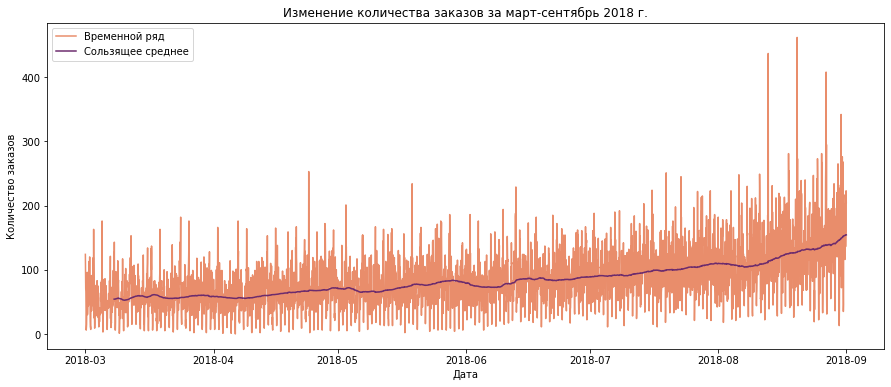

In [46]:
plt.figure(figsize=(15,6))
sns.lineplot(x=df_hours.index, y=df_hours['num_orders'], color = color[0], label='Временной ряд')
sns.lineplot(x=df_hours.index, y=df_hours['num_orders'].rolling(168).mean(), color = color[5], label='Сользящее среднее')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Изменение количества заказов за март-сентябрь 2018 г.')
plt.legend()
plt.show()

## Анализ

Декомпозируем данные по часу.

In [12]:
df_decomposed = seasonal_decompose(df_hours)

Мы можем наблюдать положительный тренд – число заказов растёт по месяцам. Из графика сезонности видно, что она есть, но её природу на данный момент определить сложно, поэтому рассмотрим её более детально. Остатки декомпозиции – стационарный стохастический процесс, т.к. среднее и десперсия не меняются на протяжении всего времени.

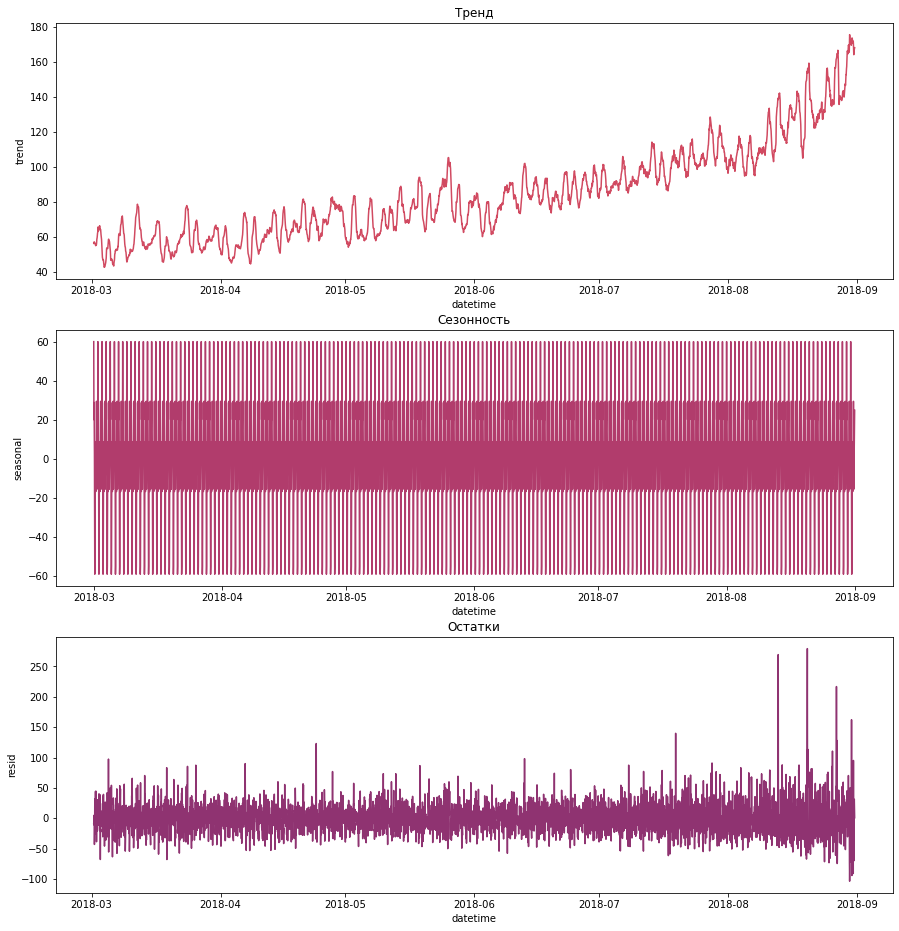

In [13]:
plt.figure(figsize=(15,16))

plt.subplot(311)
sns.lineplot(df_decomposed.trend, ax=plt.gca(), color=color[2])
plt.title('Тренд')

plt.subplot(312)
sns.lineplot(df_decomposed.seasonal, ax=plt.gca(), color=color[3])
plt.title('Сезонность')

plt.subplot(313)
sns.lineplot(df_decomposed.resid, ax=plt.gca(), color=color[4])
plt.title('Остатки')
plt.show()

Рассмотрим сезонность. Мы явно наблюдаем сезонность по дням, а в большем масштабе – по неделям (см. граффики ниже). Мы должны учесть это при генерации признаков. Поэтому возьмем скользящее среднее по дням – 24, а разность временных рядов за неделю – 168.

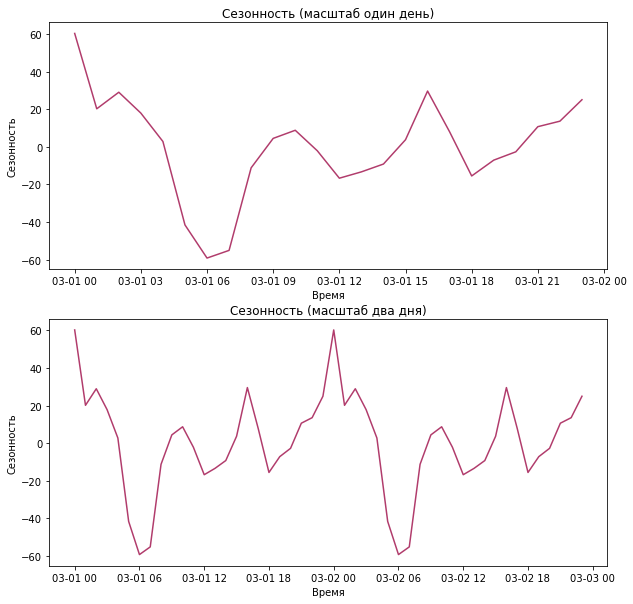

In [14]:
plt.figure(figsize=(10,10))

plt.subplot(211)
sns.lineplot(df_decomposed.seasonal[:24], ax=plt.gca(), color=color[3])
plt.title('Сезонность (масштаб один день)')
plt.xlabel('Время')
plt.ylabel('Сезонность')

plt.subplot(212)
sns.lineplot(df_decomposed.seasonal[:48], ax=plt.gca(), color=color[3])
plt.title('Сезонность (масштаб два дня)')
plt.xlabel('Время')
plt.ylabel('Сезонность')
plt.show()

Декомпозируем данные по неделям, чтобы увидеть сезонность в другом масштабе. Для этого нам сначала необходимо ресемплировать их по дням.

In [15]:
df_weeks = df.resample('1D').sum().copy()
df_decomposed2 = seasonal_decompose(df_weeks)

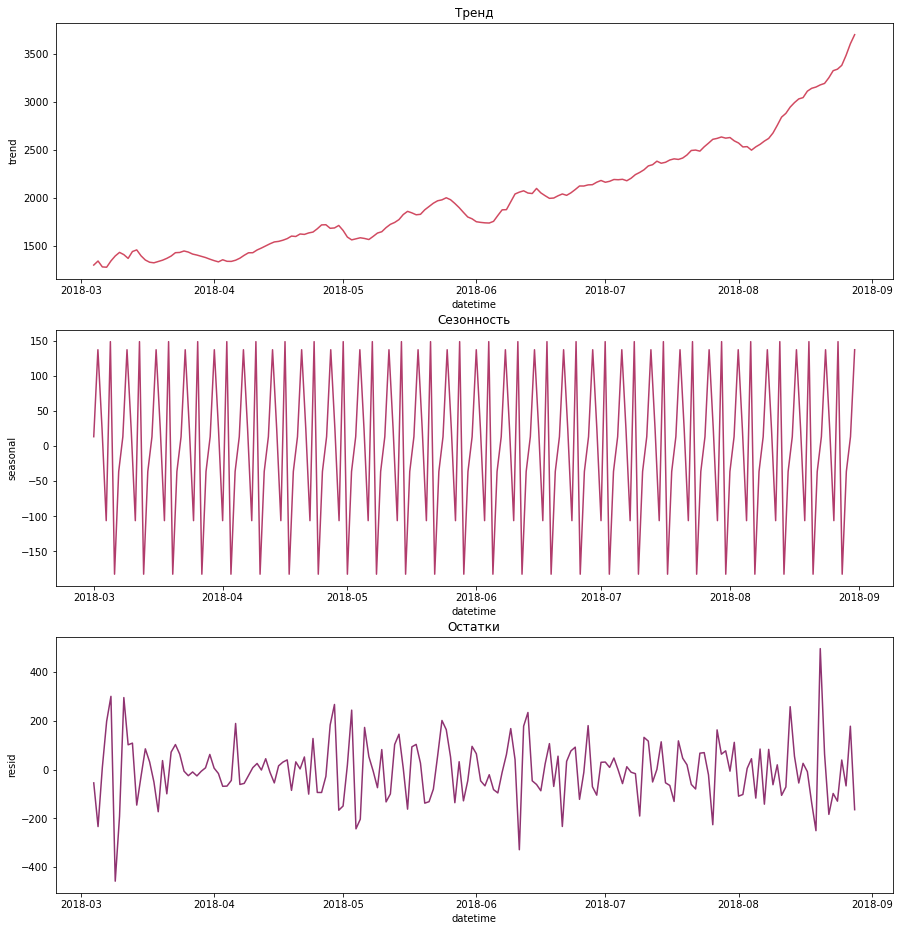

In [16]:
plt.figure(figsize=(15,16))

plt.subplot(311)
sns.lineplot(df_decomposed2.trend, ax=plt.gca(), color=color[2])
plt.title('Тренд')

plt.subplot(312)
sns.lineplot(df_decomposed2.seasonal, ax=plt.gca(), color=color[3])
plt.title('Сезонность')

plt.subplot(313)
sns.lineplot(df_decomposed2.resid, ax=plt.gca(), color=color[4])
plt.title('Остатки')
plt.show()

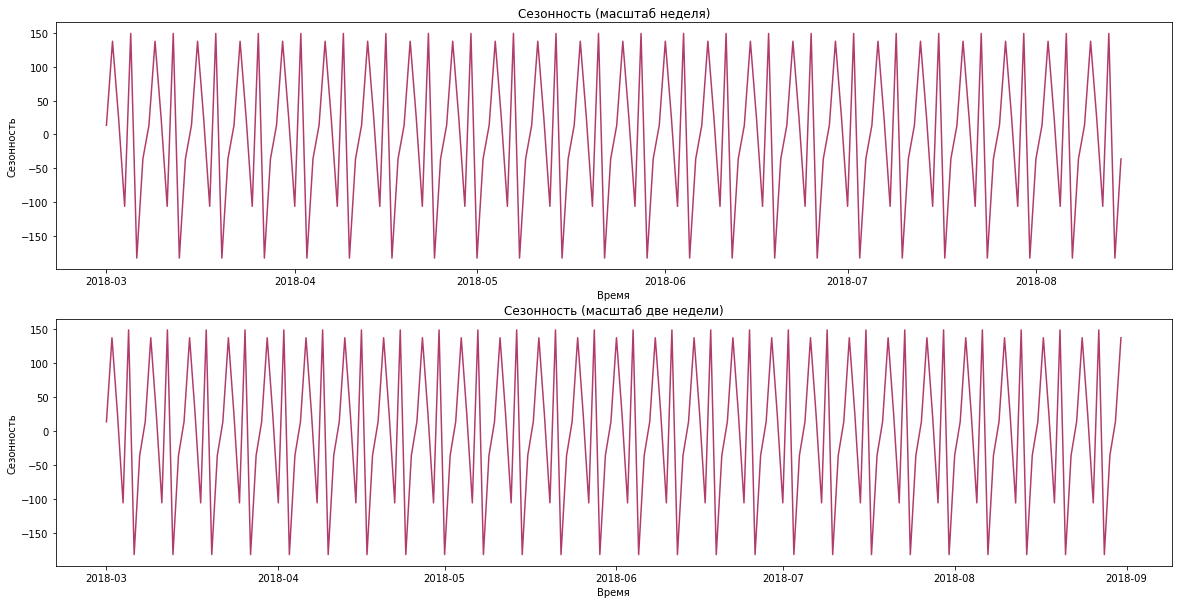

In [17]:
plt.figure(figsize=(20,10))

plt.subplot(211)
sns.lineplot(df_decomposed2.seasonal[:168], ax=plt.gca(), color=color[3])
plt.title('Сезонность (масштаб неделя)')
plt.xlabel('Время')
plt.ylabel('Сезонность')

plt.subplot(212)
sns.lineplot(df_decomposed2.seasonal[:336], ax=plt.gca(), color=color[3])
plt.title('Сезонность (масштаб две недели)')
plt.xlabel('Время')
plt.ylabel('Сезонность')
plt.show()

Мы используем функцию `make_features` для генерации календарных признаков, разностей временного ряда и скользящего среднего. Мы выбрали в качестве признаков час и день недели, поскольку мы наблюдаем недельную и дневную сезонность.

In [18]:
def make_features(data, max_lag=1, rolling_mean_size=1):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [19]:
make_features(df_hours, max_lag=168, rolling_mean_size=24)
display(df_hours.head())

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Далее мы сгенерируем тригонометрические признаки из переменных "день недели" и "час". Использлвание синуса и косинуса позволит получить нам подобие циферблата часов. Подробнее см. по [ссылке](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html).

In [20]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [21]:
transformer = ColumnTransformer(
    transformers=[
        ("hour_sin", sin_transformer(24), ["hour"]),
        ("hour_cos", cos_transformer(24), ["hour"]),
        ("dayofweek_sin", sin_transformer(7), ["dayofweek"]),
        ("dayofweek_cos", cos_transformer(7), ["dayofweek"]),
    ],
    remainder='passthrough',
)

## Обучение

Разделим выборку на тестовую и обучающую в пропорции 90:10. Удалим пропущенные значения из обучающего массива. Убедимся, что пропуски удалены.

In [22]:
train, test = train_test_split(df_hours, shuffle=False, test_size=0.1)
print(train.shape, test.shape)

(3974, 172) (442, 172)


In [23]:
train = train.dropna()
print(f'Число пропусков в массиве train: {train.isna().sum().sum()}')

Число пропусков в массиве train: 0


Разделим признаки и таргет, присвоим их соответсвующим переменным.

In [24]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(3806, 171) (3806,)
(442, 171) (442,)


### Дамми модель

Обучим дамми модель, чтобы сравнивать с ней результаты обучения линейной регрессии, дерева решений и случайного леса.

In [25]:
dummy_model = Pipeline([('transformer', transformer), ('dummy_model', DummyRegressor())])

In [26]:
start_time = time.time()
dummy_model.fit(features_train, target_train)
dummy_time = time.time() - start_time

In [27]:
start_time = time.time()
dummy_pred = dummy_model.predict(features_train)
dummy_pred_time = time.time() - start_time

In [28]:
print('Результаты обучения\n')
print('Время обучения:', round(dummy_time, 5))
print('Время предсказания:', round(dummy_pred_time, 5))
print('RMSE на кросс-валидации:', round(np.mean(-cross_val_score(dummy_model, features_train, target_train, 
                                                                 cv=TimeSeriesSplit(n_splits=5), 
                                                                 scoring='neg_root_mean_squared_error')), 2))

Результаты обучения

Время обучения: 0.02324
Время предсказания: 0.02019
RMSE на кросс-валидации: 40.5


Более примитивный алгоритм – предсказание предыдущим значением. Результат предсказания лучше, чем у дамми регрессора.

In [29]:
pred_median = np.ones(target_train.shape)*target_train.shift(-1).fillna(method='ffill')
print('RMSE предсказания предыдущим значением:', mean_squared_error(target_train, pred_median, squared=False))

RMSE предсказания предыдущим значением: 36.348151590070074


### Линейная регрессия

Далее обучим линейную регрессию.

In [30]:
lin_model = Pipeline([('transformer', transformer), ('lin_model', LinearRegression())])

In [31]:
start_time = time.time()
lin_model.fit(features_train, target_train)
lin_time = time.time() - start_time

In [32]:
start_time = time.time()
lin_pred = lin_model.predict(features_train)
lin_pred_time = time.time() - start_time

In [33]:
print('Результаты обучения\n')
print('Время обучения:', round(lin_time, 5))
print('Время предсказания:', round(lin_pred_time, 5))
print('RMSE на кросс-валидации:', round(np.mean(-cross_val_score(lin_model, features_train, target_train, 
                                                                 cv=TimeSeriesSplit(n_splits=5), 
                                                                 scoring='neg_root_mean_squared_error')), 2))

Результаты обучения

Время обучения: 0.07476
Время предсказания: 0.02006
RMSE на кросс-валидации: 22.58


### Дерево решений

Теперь рассмотрим результаты подбора параметров и обучения дерева решений.

In [34]:
tree = Pipeline([('transformer', transformer), ('tree_model', DecisionTreeRegressor(random_state=42))])

tree_params = {'tree_model__max_depth': range(2, 10),
               'tree_model__min_samples_leaf': range(2, 6),
               'tree_model__min_samples_split': range(1, 4)}

tree_model = GridSearchCV(tree, param_grid=tree_params, 
                          cv=TimeSeriesSplit(n_splits=5), 
                          scoring='neg_root_mean_squared_error')

In [35]:
start_time = time.time()
tree_model.fit(features_train, target_train)
tree_time = time.time() - start_time

In [36]:
print('Результаты подбора параметров.\n')
print(f'Время подбора параметров: {round(tree_time, 2)} сек')
print(f'Время обучения модели: {round(tree_model.cv_results_["mean_fit_time"][tree_model.best_index_], 5)} сек')
print(f'Время предсказания модели: {round(tree_model.cv_results_["mean_score_time"][tree_model.best_index_], 5)} сек')
print('Лучшие значения параметров:')
pprint.pprint(tree_model.best_params_)

Результаты подбора параметров.

Время подбора параметров: 40.72 сек
Время обучения модели: 0.08629 сек
Время предсказания модели: 0.00459 сек
Лучшие значения параметров:
{'tree_model__max_depth': 4,
 'tree_model__min_samples_leaf': 4,
 'tree_model__min_samples_split': 2}


In [37]:
print('Результаты оценки модели на кросс-валидации.\n')
print('RMSE на кросс-валидации:', round(np.mean(-cross_val_score(tree_model.best_estimator_, features_train, target_train, 
                                                                 cv=TimeSeriesSplit(n_splits=5), 
                                                                 scoring='neg_root_mean_squared_error')), 2))

Результаты оценки модели на кросс-валидации.

RMSE на кросс-валидации: 26.47


### Случайный лес

Наконец, рассмотим случайный лес. В процессе подбора параметров качество дерева решений не менялось, при условии, что число эстиматоров было более 50. При этом максимальная глубина – стабильно 9.

In [38]:
forest = Pipeline([('transformer', transformer), ('forest_model', RandomForestRegressor(random_state=42, n_jobs=-1))])

forest_params = {'forest_model__max_depth': range(3, 15),
                 'forest_model__n_estimators': [70, 80, 85]}

forest_model = GridSearchCV(forest, param_grid=forest_params, 
                            cv=TimeSeriesSplit().split(features_train), 
                            scoring='neg_root_mean_squared_error')

In [39]:
start_time = time.time()
forest_model.fit(features_train, target_train)
forest_time = time.time() - start_time

In [40]:
print('Результаты подбора параметров.\n')
print(f'Время подбора параметров: {round(forest_time/60, 2)} мин')
print(f'Время обучения модели: {round(forest_model.cv_results_["mean_fit_time"][forest_model.best_index_], 5)} сек')
print(f'Время предсказания модели: {round(forest_model.cv_results_["mean_score_time"][forest_model.best_index_], 5)} сек')
print('Лучшие значения параметров:')
pprint.pprint(forest_model.best_params_)

Результаты подбора параметров.

Время подбора параметров: 5.65 мин
Время обучения модели: 2.8092 сек
Время предсказания модели: 0.02047 сек
Лучшие значения параметров:
{'forest_model__max_depth': 14, 'forest_model__n_estimators': 85}


In [41]:
print('Результаты оценки модели на кросс-валидации.\n')
print('RMSE на кросс-валидации:', round(np.mean(-cross_val_score(forest_model.best_estimator_, features_train, target_train, 
                                                                 cv=TimeSeriesSplit(n_splits=5), 
                                                                 scoring='neg_root_mean_squared_error')), 2))

Результаты оценки модели на кросс-валидации.

RMSE на кросс-валидации: 22.79


**Вывод:** Все три модели справляются лучше, чем предсказание средним (дамми регрессов) и предсказание "задним числом", т.е. предыдущим значением. Рассмотрев три модели и сравнив их с дамми регрессором, мы пришли к выводу, что лучшие результаты у линейной регрессии. Она работает медленнее дерева решений, но RMSE на кросс-валидации у линейной регрессии ниже. Дерево решений показывает примерно такой же результат обучения, но обучается дольше. Поэтому, предлагается использовать линейную модель для предсказания.

|Модель|Время обучения|Время предсказания|RMSE на кросс-валидации|
|:-----|:-------------|:-----------------|:----------------------|
|Linear Regression| 0.075 s|0.020 s|22.58|
|Random Forest Regressor|2.810 s|0.020 s|22.79|
|Decision Tree Regressor|0.086 s|0.005 s|26.47|
|Dummy Regressor|0.023 s|0.020 s|40.5|

## Тестирование

Предлагается использовать линейную регрессию для прогнозирования количества заказов такси на следующий час.

In [43]:
print('RMSE на тестовой выборке:', mean_squared_error(target_test, lin_model.predict(features_test), squared=False))

RMSE на тестовой выборке: 34.44333955477143


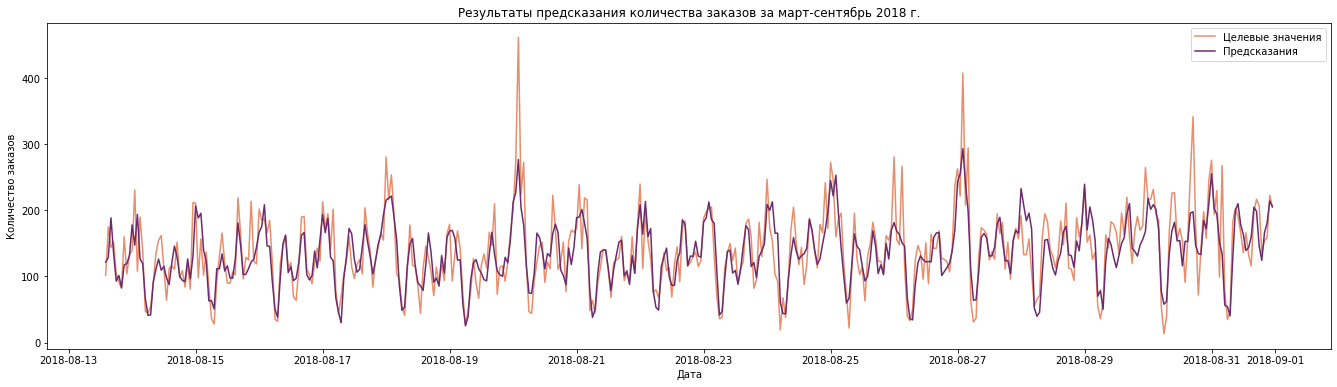

In [45]:
plt.figure(figsize=(23,6))
sns.lineplot(x=target_test.index, y=target_test, color = color[0], label='Целевые значения')
sns.lineplot(x=target_test.index, y=lin_model.predict(features_test), color = color[5], label='Предсказания')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Результаты предсказания количества заказов за март-сентябрь 2018 г.')
plt.legend()
plt.show()

## Вывод

Цель проекта – выбрать модель для прогнозирования количества заказов такси на следующий час. В качестве метрики качества была выбрана RMSE, пороговое значение ошибки – не больше 48 заказов. На первом этапе мы предобработали данные – сгруппировали их по часам и взяли среднее за каждый. На втором этапе были проанализироваы данные по заказам такси в марте-сентябре 2018 года. Был выявлен положительный тренд – рост заказов с каждым месяцем, а также дневная и недельная сезонность. По результатам анализа были сгенерированы новые переменные: календарные значения (час и день недели), скользящее среднее за сутки (24 часа) и лаг за неделю (168 часов). Далее были обучены и оценены три модели: линейная регрессия, дерево решений и случайный лес. Результаты моделей сравнивались между собой, а также с базовой моделью – дамми регрессором – и с моделью, выдающей в качестве предсказаний значения за предыдущий период (час). По результатам обучения и оценки моделей на кросс-валидации **линеная регрессия** показала лучшие результаты. Поэтому мы выбрали эту модель в качестве финальной. RMSE на тестовой выборке – 34.44. 